# Project 1: Credit Card Fraud 
Please put "creditcard_sample.csv" into the root folder, same location as this ipynb file.

In [4]:

# reading in the data:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("creditcard_sample.csv")
df.head()

train, test = train_test_split(df, test_size=0.2, random_state=17)

x_rows = ["Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount"]
y_row = "Class"

train_x = train[x_rows]
train_y = train[y_row]

test_x = test[x_rows]
test_y = test[y_row]

In [5]:
# how many cases?
len(df)
# how many fraud cases?
len(df[df["Class"] == 1])
# should give 223!! if it does not, the data was not read correctly

223

In [191]:
# some preparation for the evaluation of undersampling later on
from sklearn.utils import shuffle

def under_sample_majority(train, random_state=11922105):
    n = min(len(train[train["Class"] == 1]), len(train[train["Class"] == 0]))
    c1 = train[train["Class"] == 1].sample(n=n, random_state=random_state)
    c2 = train[train["Class"] == 0].sample(n=n, random_state=random_state)
    res = shuffle(pd.concat([c1,c2]), random_state=random_state)
    return res

train_undersampled = under_sample_majority(train)

train_u_x = train_undersampled[x_rows]
train_u_y = train_undersampled[y_row]

print(train_u_y)


42784    1
88897    1
5379     0
88258    1
90388    0
        ..
53591    1
31480    0
1821     0
36543    0
23922    0
Name: Class, Length: 362, dtype: int64


# Classical classification methods

- Logistic regression (LR)
- support vector machine (SVM)
- random forest (RF)


In [172]:
# logistic regression
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 4000)
reg.fit(train_x, train_y)
test_y_pred_log_reg = reg.predict(test_x) 

In [173]:
# support vector machine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_x, train_y)
test_y_pred_svm = svm.predict(test_x) 


In [174]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(train_x, train_y)
test_y_pred_rfc = rfc.predict(test_x) 


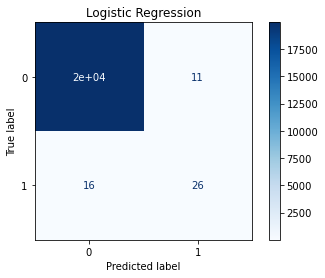

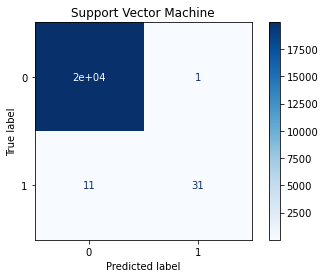

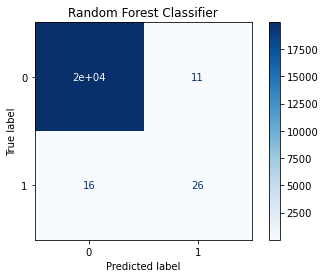

In [183]:
from sklearn.metrics import confusion_matrix as confusion_matrix_bad_impl, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import os
if not os.path.exists("latex/images/"):
    os.makedirs("latex/images/")

def confusion_matrix(y_true, y_pred):
    # is bad because does not always give 2x2 array as output
    c = confusion_matrix_bad_impl(y_true, y_pred)
    if(len(c) == 1):
        val = c[0][0]
        a = np.array([[0,0],[0,0]])
        if y_true[0]:
            a[1,1] = val
            return a
        else:
            a[0,0] = val
            return a
    return np.array(c)

def plot_confusion_matrix(true,predicted, title="", path=""):
    plot_confusion_matrix_from_matrix(confusion_matrix(true, predicted), title=title, path=path)

def plot_confusion_matrix_from_matrix(confusion_matrix, title="", path=""):
    d = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    fig, ax = plt.subplots()
    d.plot(cmap="Blues", ax=ax)
    ax.set_title(title)
    if(path != ""):
        fig.savefig(path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(test_y, reg.predict(test_x), title="Logistic Regression", path="latex/images/reg_conf1.png")

plot_confusion_matrix(test_y, svm.predict(test_x), title="Support Vector Machine", path="latex/images/svm_conf1.png")

plot_confusion_matrix(test_y, rfc.predict(test_x), title="Random Forest Classifier", path="latex/images/rfc_conf1.png")

In [184]:
def acc_prec_rec_f1(true_labels, predicted_labels):
    return acc_prec_rec_f1_from_conf(confusion_matrix(true_labels, predicted_labels))

def acc_prec_rec_f1_from_conf(confusion_matrix):
    tn, tp, fp, fn = tn_tp_fp_fn_from_conf(confusion_matrix)
    acc = (tp+tn)/(tn + tp + fp + fn)
    prec = tp/(tp+fp)
    rec = tp / (fn + tp)
    f1 = 2 * prec * rec /(prec + rec)
    return [round(e,9) for e in [acc, prec,rec, f1]]

def tn_tp_fp_fn_from_conf(confusion_matrix):
    return confusion_matrix[0,0], confusion_matrix[1,1], confusion_matrix[0,1], confusion_matrix[1,0]


tmpl = "{}: \nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}\n"

print(tmpl.format("Logistic Regression", *acc_prec_rec_f1(test_y, test_y_pred_log_reg)))
print(tmpl.format("Support Vector Machine", *acc_prec_rec_f1(test_y, test_y_pred_svm)))
print(tmpl.format("Random Forest Classifier", *acc_prec_rec_f1(test_y, test_y_pred_rfc)))


Logistic Regression: 
Accuracy: 0.99865
Precision: 0.702702703
Recall: 0.619047619
F1: 0.658227848

Support Vector Machine: 
Accuracy: 0.9994
Precision: 0.96875
Recall: 0.738095238
F1: 0.837837838

Random Forest Classifier: 
Accuracy: 0.99865
Precision: 0.702702703
Recall: 0.619047619
F1: 0.658227848



ROC for Logistic Regression. AUC = 0.8092


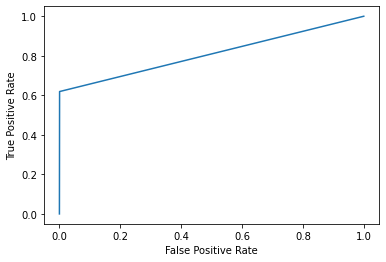

PRC for Logistic Regression. AUC = 0.4358


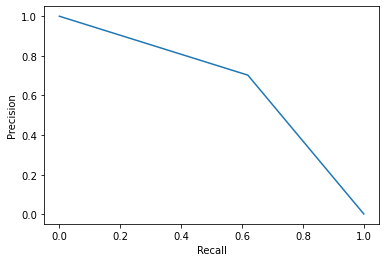

ROC for Support Vector Machine. AUC = 0.869


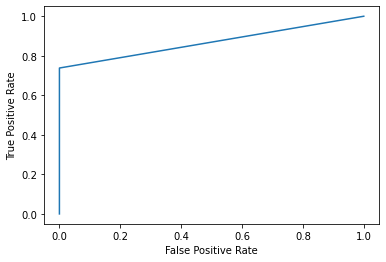

PRC for Support Vector Machine. AUC = 0.7156


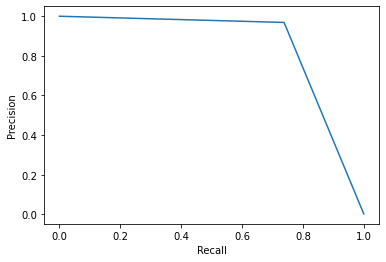

ROC for Random Forest Classifier. AUC = 0.8092


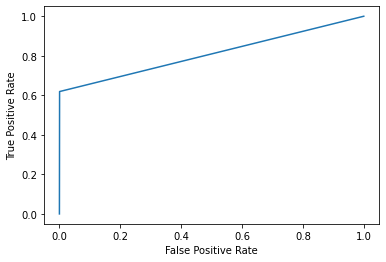

PRC for Random Forest Classifier. AUC = 0.4358


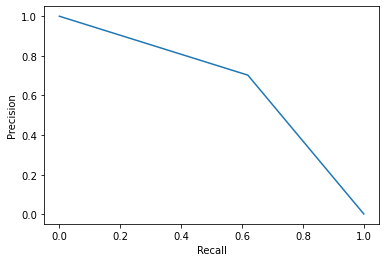

In [168]:
from sklearn import metrics
# roc curves and prc curves and their scores:
def roc_and_prc(y_true, y_pred, title,  roc_path, prc_path):
    roc_fpr, roc_tpr, _ = metrics.roc_curve(y_true,  y_pred)
    roc_auc = metrics.roc_auc_score(y_true,  y_pred)
    prc_prec, prc_rec, _ = metrics.precision_recall_curve(
            y_true,  y_pred)
    prc_auc = metrics.average_precision_score(y_true,  y_pred)
    fig, ax = plt.subplots()
    ax.plot(roc_fpr, roc_tpr)
    print(f"ROC for {title}. AUC = {round(roc_auc,4)}")
    # ax.set_title(f"{title} ROC curve\n area under curve = {roc_auc:1f}")
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    if roc_path:
        fig.savefig(roc_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    fig, ax = plt.subplots()
    ax.plot(prc_rec, prc_prec)
    # ax.set_title()
    print(f"PRC for {title}. AUC = {round(prc_auc,4)}")
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    if prc_path:
        fig.savefig(prc_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()


roc_and_prc(test_y, test_y_pred_log_reg, "Logistic Regression", "latex/images/reg_roc.png", "latex/images/reg_prc.png")
roc_and_prc(test_y, test_y_pred_svm, "Support Vector Machine", "latex/images/svm_roc.png", "latex/images/svm_prc.png")
roc_and_prc(test_y, test_y_pred_rfc, "Random Forest Classifier", "latex/images/rfc_roc.png", "latex/images/rfc_prc.png")

In [143]:
# DNN definition
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


def create_binary_classification_model(input_layer_size = 30, hidden_layers = 2, hidden_layer_size = 10) -> nn.Sequential:
    layers = [
        ("hidden_layer_1", nn.Linear(input_layer_size, hidden_layer_size)),
        ("activation_1", nn.ReLU())        
    ]
   
    for i in range(2, hidden_layers+1):
        layers.append((f"hidden_layer_{i}",nn.Linear(hidden_layer_size, hidden_layer_size) ))
        layers.append((f"activation_{i}",  nn.ReLU()))

    layers.append(("output_layer", nn.Linear(hidden_layer_size, 1)) )
    layers.append(("softmax", nn.Sigmoid()))
    return nn.Sequential(OrderedDict(layers))

def batch_iterator(xes, y, batch_size):
    
    for i in range(0, xes.shape[0], batch_size):
        yield (xes[i:i + batch_size], y[i:i + batch_size])


In [144]:
# create training and test data for torch
torch_train_x = torch.from_numpy(train_x.to_numpy()).float()
torch_train_u_x = torch.from_numpy(train_u_x.to_numpy()).float()
torch_test_x = torch.from_numpy(test_x.to_numpy()).float()
torch_train_y = torch.from_numpy(train_y.to_numpy()).unsqueeze(1).float()
torch_train_u_y = torch.from_numpy(train_u_y.to_numpy()).unsqueeze(1).float()
torch_test_y = torch.from_numpy(test_y.to_numpy()).unsqueeze(1).float()

print(torch_train_x.size())
print(torch_train_y.size())
print(torch_train_u_x.size())
print(torch_train_u_y.size())
print(torch_test_x.size())
print(torch_test_y.size())

torch.Size([79999, 30])
torch.Size([79999, 1])
torch.Size([362, 30])
torch.Size([362, 1])
torch.Size([20000, 30])
torch.Size([20000, 1])


In [198]:
%pip install torchmetrics
import typing
import sklearn
import json

from torchmetrics import Accuracy
from sklearn import metrics


def confusion_matrix_to_accuracy(confusion):
    return (confusion[0, 0] + confusion[1, 1]) / confusion_matrix_to_sample_count(confusion)


def confusion_matrix_to_sample_count(confusion):
    return confusion[0, 0] + confusion[0, 1] + confusion[1, 0] + confusion[1, 1]


accuracy = Accuracy()


def determine_device():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    return DEVICE


class TrainSettings:
    EPOCHS = 4
    BATCH_SIZE = 64
    LR = 0.001
    LOSS_FUNCTION = nn.BCELoss()
    DEVICE = determine_device()

    def __init__(self, EPOCHS=4, BATCH_SIZE=64, LR=0.001, LOSS_FUNCTION=nn.BCELoss(), ) -> None:
        self.DEVICE = determine_device()
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.LR = LR
        self.LOSS_FUNCTION = LOSS_FUNCTION


class EpochStats:
    train_loss: float
    test_loss: float
    epoch: int

    def __init__(self, epoch, train_loss, train_conf, test_loss, test_conf) -> None:
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.train_confusion = train_conf
        self.test_confusion = test_conf


class TrainStats:
    train_settings: TrainSettings
    epochs: typing.List[EpochStats]

    def report_files_gen(self):
        last_epoch = self.epochs[-1]
        dic = dict()
        print("last_epoch.test_confusion")
        print(last_epoch.test_confusion)

        tn, tp, fp, fn = tn_tp_fp_fn_from_conf(last_epoch.test_confusion)
        dic["test_tn"] = tn
        dic["test_tp"] = tp
        dic["test_fp"] = fp
        dic["test_fn"] = fn

        tn, tp, fp, fn = tn_tp_fp_fn_from_conf(last_epoch.train_confusion)
        dic["train_tn"] = tn
        dic["train_tp"] = tp
        dic["train_fp"] = fp
        dic["train_fn"] = fn

        acc, prec, rec, f1 = acc_prec_rec_f1_from_conf(
            last_epoch.test_confusion)
        dic["test_acc"] = acc
        dic["test_prec"] = prec
        dic["test_rec"] = rec
        dic["test_f1"] = f1

        acc, prec, rec, f1 = acc_prec_rec_f1_from_conf(
            last_epoch.train_confusion)
        dic["train_acc"] = acc
        dic["train_prec"] = prec
        dic["train_rec"] = rec
        dic["train_f1"] = f1

        dic["roc_auc"] = self.roc_auc
        dic["prc_auc"] = self.prc_auc

        dic["test_loss"] = last_epoch.test_loss
        dic["train_loss"] = last_epoch.train_loss

        dic["EPOCHS"] = self.train_settings.EPOCHS
        dic["BATCH_SIZE"] = self.train_settings.BATCH_SIZE
        dic["LR"] = self.train_settings.LR
        dic["name"] = self.identifier()

        # with open(f"{self._savepath()}report.json", "w+") as outfile:
        #     json.dump(dic, outfile)
        with open(f"{self._savepath()}report.txt", "w+") as outfile:
            keys = ["name", "EPOCHS", "BATCH_SIZE", "LR",
                    "train_tn", 
                    "train_tp", 
                    "train_fp", 
                    "train_fn",
                    "test_tn",
                    "test_tp",
                    "test_fp",
                    "test_fn",
                    "train_acc",
                    "train_prec",
                    "train_rec",
                    "train_f1",
                    "test_acc",
                    "test_prec",
                    "test_rec",
                    "test_f1",
                    "roc_auc",
                    "prc_auc",
                    "train_loss",
                    "test_loss"]
            s = ""
            s += " & ".join([k.ljust(20, ' ') for k in keys]) + "\n"
            s += " & ".join([str(dic[k]).ljust(20, ' ') for k in keys])+ "\n"
            outfile.write(s)

    # def add_epoch(train_loss)

    def __init__(self, train_settings, name) -> None:
        self.train_settings = train_settings
        self.epochs = []
        self.name = name

    def identifier(self) -> str:
        return f"{self.name}_E{self.train_settings.EPOCHS}_LR{self.train_settings.LR}_B{self.train_settings.BATCH_SIZE}"

    def calc_roc_and_prc_curves(self, y_true, y_pred):
        self.roc_fpr, self.roc_tpr, _ = metrics.roc_curve(y_true,  y_pred)
        self.roc_auc = metrics.roc_auc_score(y_true,  y_pred)
        self.prc_prec, self.prc_rec, _ = metrics.precision_recall_curve(
            y_true,  y_pred)
        self.prc_auc = metrics.average_precision_score(y_true,  y_pred)

    def _savepath(self):
        return f"latex/images/{self.identifier()}/"

    def save_report(self, net=None):
        dirname = self._savepath()
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        if net is not None:
            torch.save(net.state_dict(), f"{dirname}model.pt")
        self.visualize_roc_and_prc_curves(save=True)
        self.visualize_loss(save=True)
        self.visualize_accuracy(save=True)
        self.plot_confusion_matrizes(save=True)
        self.report_files_gen()

    def add_epoch(self, epoch_stats: EpochStats):
        self.epochs.append(epoch_stats)

    def visualize_loss(self, save=False):
        x = [e.epoch for e in self.epochs]
        fig, ax = plt.subplots()
        ax.plot(x, [e.train_loss for e in self.epochs], label="Train Loss")
        ax.plot(x, [e.test_loss for e in self.epochs], label="Test Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        if save:
            fig.savefig(f"{self._savepath()}loss.png",
                        format='png', dpi=300, bbox_inches='tight')
        plt.show()

    def visualize_accuracy(self, save=False):
        x = [e.epoch for e in self.epochs]
        fig, ax = plt.subplots()
        ax.plot(x, [confusion_matrix_to_accuracy(e.test_confusion)
                for e in self.epochs], label="Train Accuracy")
        ax.plot(x, [confusion_matrix_to_accuracy(e.train_confusion)
                for e in self.epochs], label="Test Accuracy")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        if save:
            fig.savefig(f"{self._savepath()}accuracy.png",
                        format='png', dpi=300, bbox_inches='tight')

    def visualize_roc_and_prc_curves(self, save=False):
        fig, ax = plt.subplots()
        ax.plot(self.roc_fpr, self.roc_tpr)
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        if save:
            fig.savefig(f"{self._savepath()}roc.png",
                        format='png', dpi=300, bbox_inches='tight')
        plt.show()
        fig, ax = plt.subplots()
        ax.plot(self.prc_rec, self.prc_prec)
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        if save:
            fig.savefig(f"{self._savepath()}prc.png",
                        format='png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrizes(self, save=False):
        path_test = f"{self._savepath()}conf_test.png"
        path_train = f"{self._savepath()}conf_train.png"
        plot_confusion_matrix_from_matrix(self.epochs[len(
            self.epochs)-1].train_confusion, "Train Confusion Matrix", path=path_train if save else "")
        plot_confusion_matrix_from_matrix(self.epochs[len(
            self.epochs)-1].test_confusion, "Test Confusion Matrix", path=path_test if save else "")


In [147]:
# training function to turn a model into a trained network
from typing import Tuple

def train_network_from_model(model, train_x, train_y, test_x, test_y, train_settings: TrainSettings = TrainSettings(), name="") ->  Tuple[nn.Sequential,TrainStats] :
    print(f"using {train_settings.DEVICE} for training, EPOCHS={train_settings.EPOCHS}, BATCH_SIZE={train_settings.BATCH_SIZE}, LR={train_settings.LR}")
    
    network = model.to(train_settings.DEVICE)
    optimizer = Adam(network.parameters(), lr=train_settings.LR)
    train_stats = TrainStats(train_settings, name=f"{name}")
    for epoch in range(1, train_settings.EPOCHS+1):
        print(f"EPOCH {epoch}:")
        train_loss, train_conf = train_network(network, optimizer, train_x, train_y, train_settings)
        test_loss, test_conf = evaluate_network(network, test_x, test_y, train_settings, train_stats_to_calculate_curves_for = train_stats if epoch == train_settings.EPOCHS else None)
        train_stats.add_epoch(EpochStats(epoch, train_loss, train_conf, test_loss, test_conf))
    return (network, train_stats)

def train_network(network, optimizer, train_x, train_y, train_settings: TrainSettings):
    loss, conf = 0, np.array([[0,0],[0,0]])
    network.train()
    for (bx,by) in batch_iterator(train_x, train_y, train_settings.BATCH_SIZE):
        l, c = train_network_on_batch(network, optimizer, bx,by, train_settings)
        loss += l * confusion_matrix_to_sample_count(c)
        conf += c
    loss = loss / confusion_matrix_to_sample_count(conf)
    acc = confusion_matrix_to_accuracy(conf)
    print("TRAIN: train loss: {:.5f} train accuracy: {:.5f}".format(loss,
            acc))
    return loss, conf

def train_network_on_batch(network, optimizer, bx,by,train_settings: TrainSettings):
    pred = network(bx)
    loss = train_settings.LOSS_FUNCTION(pred, by.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    conf = confusion_matrix(by == 1, pred > 0.5)
    return loss, conf

def evaluate_network(network, test_x, test_y, train_settings, train_stats_to_calculate_curves_for=None):
    network.eval() # activate eval mode
    # initialize a no-gradient context
    with torch.no_grad():
        # loop over the current batch of test data
        (test_x_1, test_y_1) = (test_x.to(train_settings.DEVICE), test_y.to(train_settings.DEVICE))
        predictions = network(test_x_1).float()   
        loss = train_settings.LOSS_FUNCTION(predictions, test_y_1.float())
        conf = confusion_matrix(test_y_1 == 1, predictions > 0.5)
        acc = confusion_matrix_to_accuracy(conf)
        if(train_stats_to_calculate_curves_for is not None):
            train_stats_to_calculate_curves_for.calc_roc_and_prc_curves(test_y_1 == 1, predictions > 0.5)
        print("EVAL: test loss: {:.5f} test accuracy: {:.5f}".format(loss, acc))
        return loss, conf 

using cpu for training, EPOCHS=3, BATCH_SIZE=128, LR=3e-05
EPOCH 1:
TRAIN: train loss: 6.11210 train accuracy: 0.84350
EVAL: test loss: 0.05205 test accuracy: 0.99730
EPOCH 2:
TRAIN: train loss: 0.05007 train accuracy: 0.99722
EVAL: test loss: 0.04626 test accuracy: 0.99750
EPOCH 3:
TRAIN: train loss: 0.04738 train accuracy: 0.99737
EVAL: test loss: 0.04429 test accuracy: 0.99760


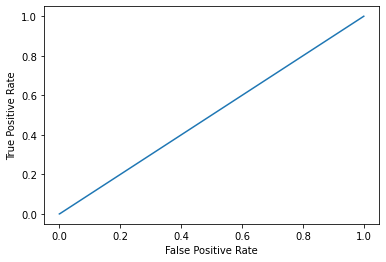

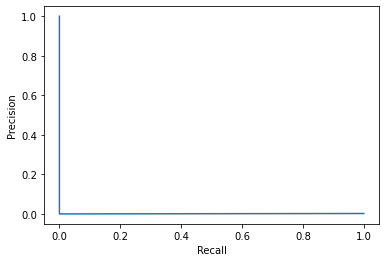

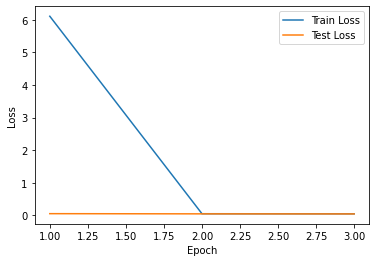

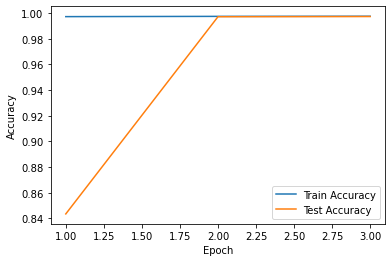

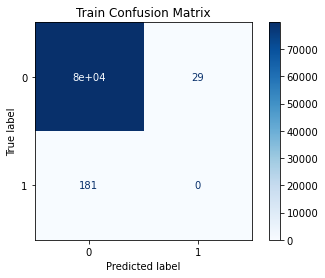

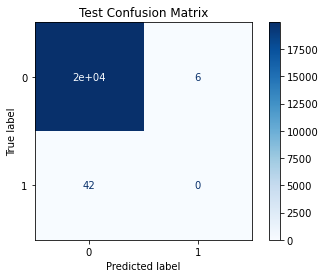

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:9: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * prec * rec /(prec + rec)


In [150]:
# how to create and train a model now (example) no good output!!
model = create_binary_classification_model(30, 4, 8)
train_settings = TrainSettings(EPOCHS=3, LR=0.00003, BATCH_SIZE=128)
net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name="net(d4xk8)")
stats.save_report(net=net)

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.01
EPOCH 1:
TRAIN: train loss: 0.22633 train accuracy: 0.99771
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21000 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0

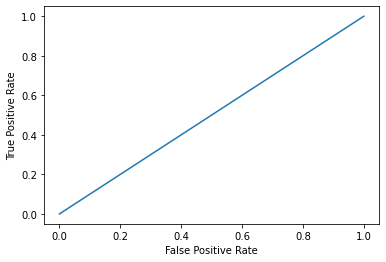

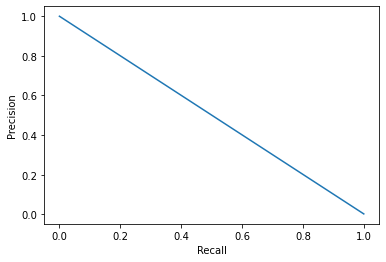

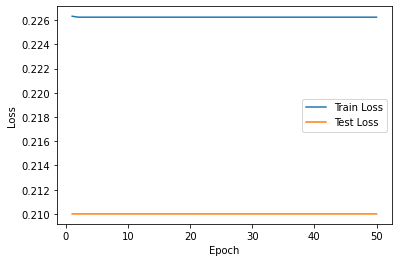

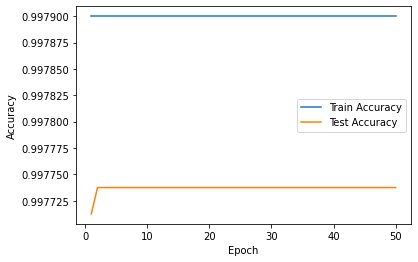

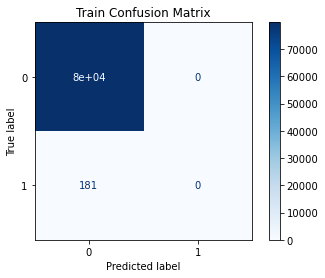

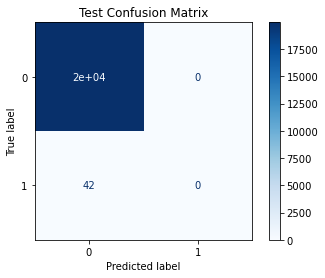

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp/(tp+fp)
C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.001
EPOCH 1:
TRAIN: train loss: 0.04728 train accuracy: 0.99482
EVAL: test loss: 0.03049 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.02985 train accuracy: 0.99774
EVAL: test loss: 0.02527 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.02344 train accuracy: 0.99774
EVAL: test loss: 0.02068 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.02001 train accuracy: 0.99774
EVAL: test loss: 0.01709 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.01742 train accuracy: 0.99774
EVAL: test loss: 0.01523 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.01522 train accuracy: 0.99774
EVAL: test loss: 0.01319 test accuracy: 0.99795
EPOCH 7:
TRAIN: train loss: 0.01394 train accuracy: 0.99804
EVAL: test loss: 0.01393 test accuracy: 0.99800
EPOCH 8:
TRAIN: train loss: 0.01501 train accuracy: 0.99782
EVAL: test loss: 0.01917 test accuracy: 0.99795
EPOCH 9:
TRAIN: train loss: 0.01559 train accuracy: 0.99781
EVAL: test loss: 

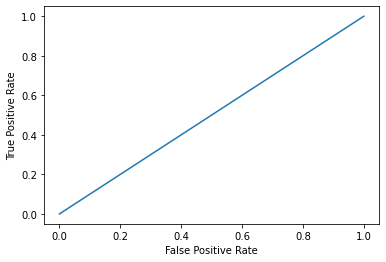

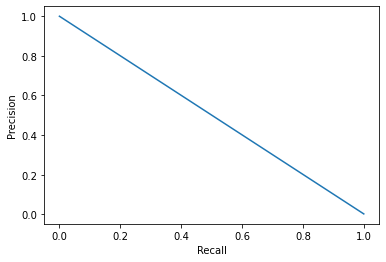

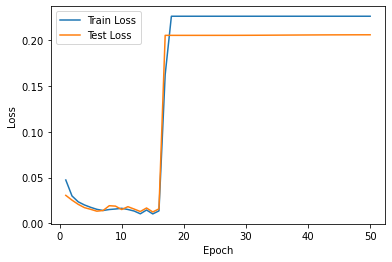

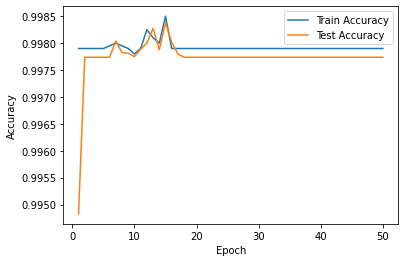

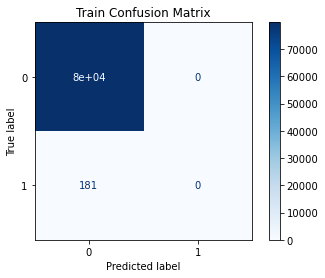

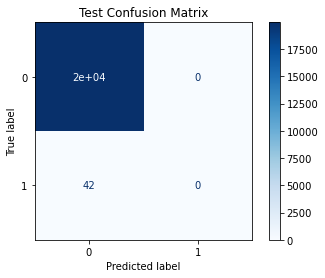

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp/(tp+fp)
C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 0.17644 train accuracy: 0.99627
EVAL: test loss: 0.13897 test accuracy: 0.99750
EPOCH 2:
TRAIN: train loss: 0.16767 train accuracy: 0.99772
EVAL: test loss: 0.12197 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.14695 train accuracy: 0.99774
EVAL: test loss: 0.09909 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.10978 train accuracy: 0.99774
EVAL: test loss: 0.06240 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.04390 train accuracy: 0.99774
EVAL: test loss: 0.03230 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.03331 train accuracy: 0.99774
EVAL: test loss: 0.02943 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.03028 train accuracy: 0.99774
EVAL: test loss: 0.02727 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.02754 train accuracy: 0.99774
EVAL: test loss: 0.02482 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.02502 train accuracy: 0.99774
EVAL: test loss:

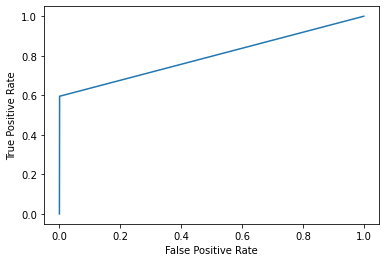

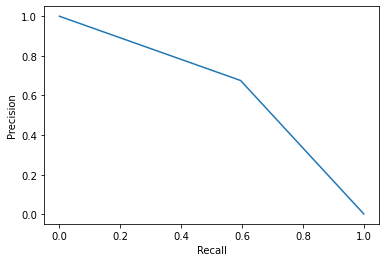

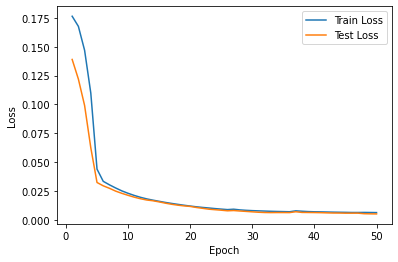

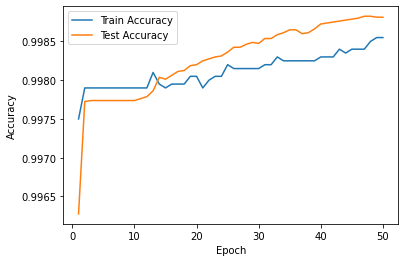

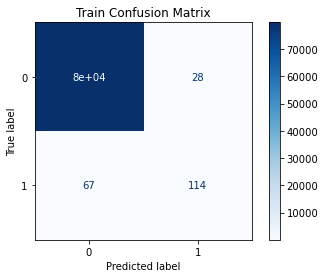

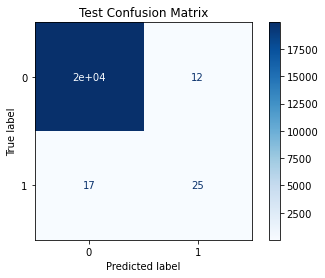

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=1e-05
EPOCH 1:
TRAIN: train loss: 0.07506 train accuracy: 0.99774
EVAL: test loss: 0.05312 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.06090 train accuracy: 0.99774
EVAL: test loss: 0.04432 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.04714 train accuracy: 0.99774
EVAL: test loss: 0.03938 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.04311 train accuracy: 0.99774
EVAL: test loss: 0.03872 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.04195 train accuracy: 0.99774
EVAL: test loss: 0.03769 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.04072 train accuracy: 0.99774
EVAL: test loss: 0.03641 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.03961 train accuracy: 0.99774
EVAL: test loss: 0.03567 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.03887 train accuracy: 0.99774
EVAL: test loss: 0.03499 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.03813 train accuracy: 0.99774
EVAL: test loss: 

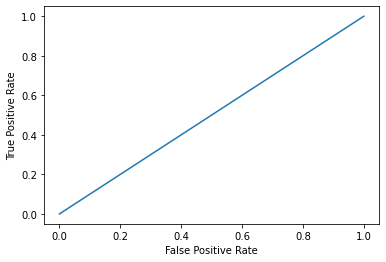

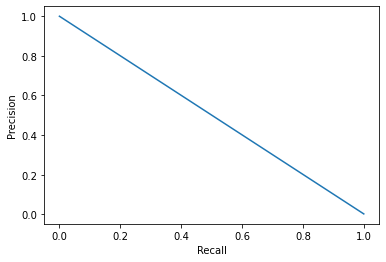

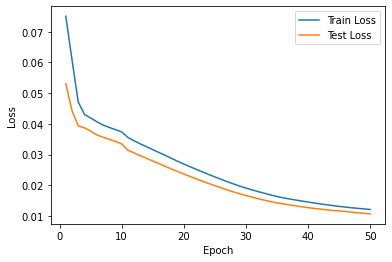

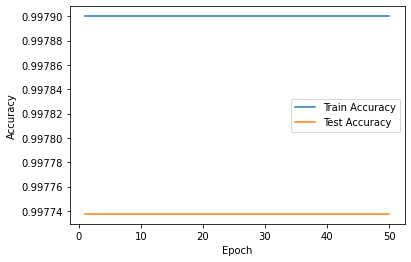

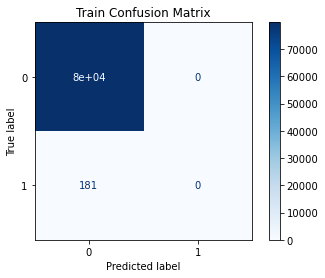

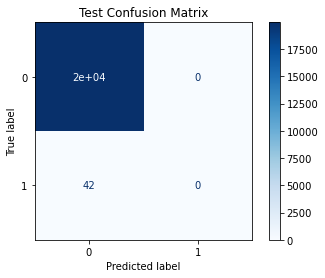

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp/(tp+fp)
C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=1e-06
EPOCH 1:
TRAIN: train loss: 3.32259 train accuracy: 0.03156
EVAL: test loss: 2.98403 test accuracy: 0.03470
EPOCH 2:
TRAIN: train loss: 2.71840 train accuracy: 0.03619
EVAL: test loss: 2.46447 test accuracy: 0.03895
EPOCH 3:
TRAIN: train loss: 2.27686 train accuracy: 0.04050
EVAL: test loss: 2.08632 test accuracy: 0.04475
EPOCH 4:
TRAIN: train loss: 1.93670 train accuracy: 0.04524
EVAL: test loss: 1.77949 test accuracy: 0.05015
EPOCH 5:
TRAIN: train loss: 1.65697 train accuracy: 0.05039
EVAL: test loss: 1.52563 test accuracy: 0.05645
EPOCH 6:
TRAIN: train loss: 1.42367 train accuracy: 0.05661
EVAL: test loss: 1.31618 test accuracy: 0.06465
EPOCH 7:
TRAIN: train loss: 1.23435 train accuracy: 0.06663
EVAL: test loss: 1.14399 test accuracy: 0.08030
EPOCH 8:
TRAIN: train loss: 1.07812 train accuracy: 0.08129
EVAL: test loss: 1.00284 test accuracy: 0.09320
EPOCH 9:
TRAIN: train loss: 0.95118 train accuracy: 0.09445
EVAL: test loss: 

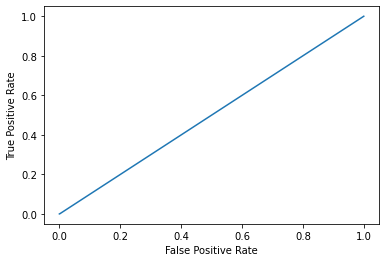

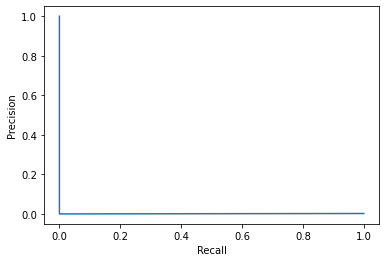

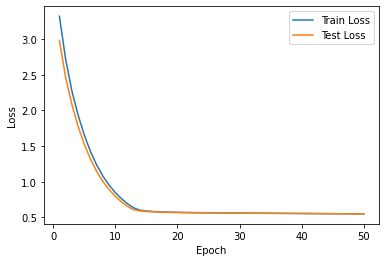

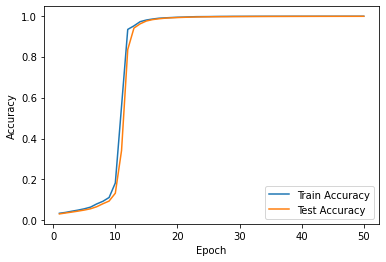

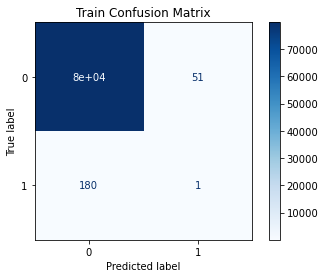

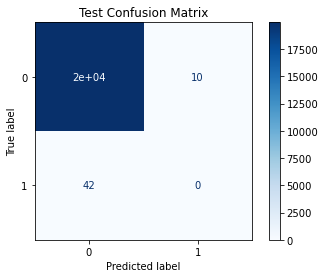

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:9: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * prec * rec /(prec + rec)


In [148]:
# Grid Search over Learning Rate, considering LR from [0.001, 0.0001, 0.00003, 0.00001, 0.000003]
for LR in [0.01, 0.001, 0.0001, 0.00001, 0.000001]:
    d = 4 # depth
    k = 8 # layer size
    model = create_binary_classification_model(30, d, k)
    train_settings = TrainSettings(EPOCHS=50, LR=LR, BATCH_SIZE=64)
    net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name=f"net(d{d}_k{k})")
    stats.save_report(net=net)

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 73.14302 train accuracy: 0.26293
EVAL: test loss: 0.17538 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.20312 train accuracy: 0.99772
EVAL: test loss: 0.17560 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.20342 train accuracy: 0.99772
EVAL: test loss: 0.17612 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.20432 train accuracy: 0.99774
EVAL: test loss: 0.17720 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.20577 train accuracy: 0.99774
EVAL: test loss: 0.17947 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.20756 train accuracy: 0.99774
EVAL: test loss: 0.18194 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.20955 train accuracy: 0.99774
EVAL: test loss: 0.18616 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.21228 train accuracy: 0.99774
EVAL: test loss: 0.18888 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.21532 train accuracy: 0.99774
EVAL: test loss

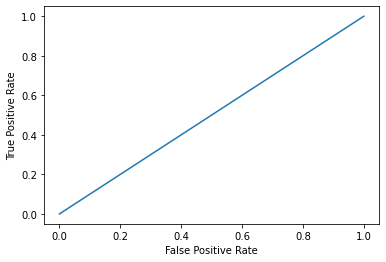

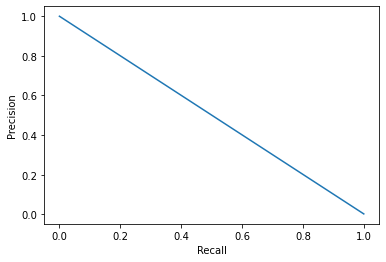

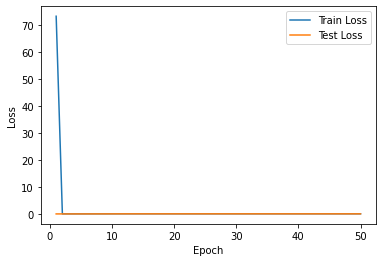

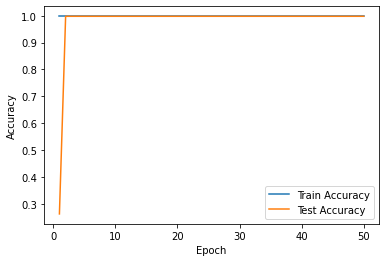

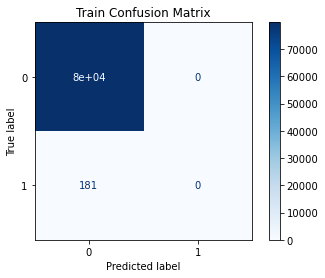

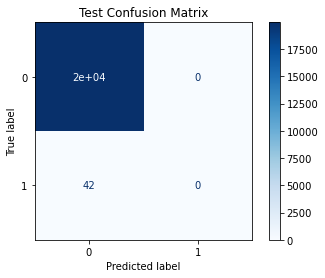

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp/(tp+fp)
C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 0.22597 train accuracy: 0.99774
EVAL: test loss: 0.20680 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.22627 train accuracy: 0.99774
EVAL: test loss: 0.20737 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.22626 train accuracy: 0.99774
EVAL: test loss: 0.20786 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.22626 train accuracy: 0.99774
EVAL: test loss: 0.20832 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.22626 train accuracy: 0.99774
EVAL: test loss: 0.20877 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.22626 train accuracy: 0.99774
EVAL: test loss: 0.20922 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21003 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss: 0.21002 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.22625 train accuracy: 0.99774
EVAL: test loss:

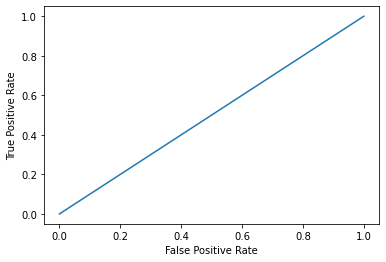

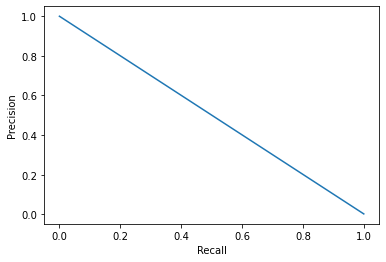

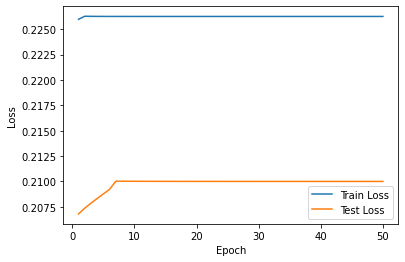

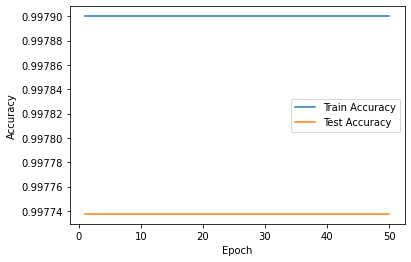

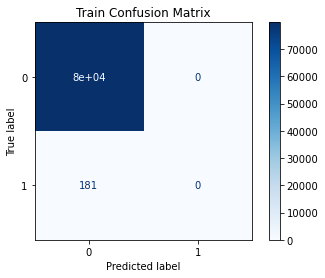

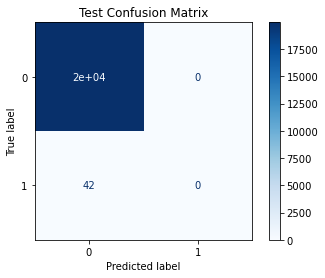

C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp/(tp+fp)
C:\Users\tadeo\AppData\Local\Temp\ipykernel_8556\2788349770.py:7: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 0.09192 train accuracy: 0.99225
EVAL: test loss: 0.03890 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.04102 train accuracy: 0.99774
EVAL: test loss: 0.03471 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.03585 train accuracy: 0.99774
EVAL: test loss: 0.03055 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.03195 train accuracy: 0.99774
EVAL: test loss: 0.02686 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.02901 train accuracy: 0.99774
EVAL: test loss: 0.02362 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.02646 train accuracy: 0.99774
EVAL: test loss: 0.02101 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.02432 train accuracy: 0.99774
EVAL: test loss: 0.01893 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.02235 train accuracy: 0.99779
EVAL: test loss: 0.01712 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.02056 train accuracy: 0.99786
EVAL: test loss:

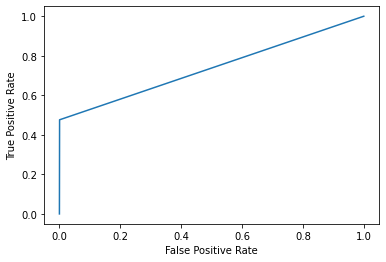

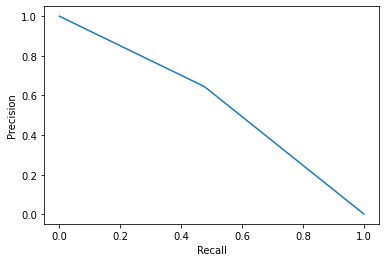

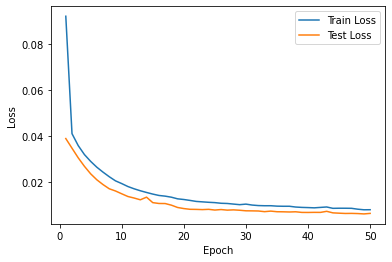

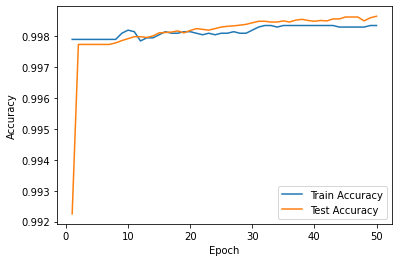

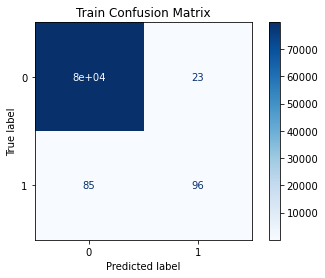

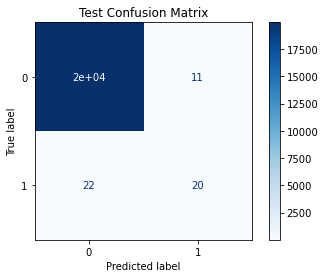

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 0.16529 train accuracy: 0.93310
EVAL: test loss: 0.03640 test accuracy: 0.99790
EPOCH 2:
TRAIN: train loss: 0.03844 train accuracy: 0.99774
EVAL: test loss: 0.03306 test accuracy: 0.99790
EPOCH 3:
TRAIN: train loss: 0.03453 train accuracy: 0.99774
EVAL: test loss: 0.02929 test accuracy: 0.99790
EPOCH 4:
TRAIN: train loss: 0.03010 train accuracy: 0.99774
EVAL: test loss: 0.02493 test accuracy: 0.99790
EPOCH 5:
TRAIN: train loss: 0.02550 train accuracy: 0.99774
EVAL: test loss: 0.02090 test accuracy: 0.99790
EPOCH 6:
TRAIN: train loss: 0.02178 train accuracy: 0.99774
EVAL: test loss: 0.01815 test accuracy: 0.99790
EPOCH 7:
TRAIN: train loss: 0.01937 train accuracy: 0.99774
EVAL: test loss: 0.01653 test accuracy: 0.99790
EPOCH 8:
TRAIN: train loss: 0.01796 train accuracy: 0.99774
EVAL: test loss: 0.01564 test accuracy: 0.99790
EPOCH 9:
TRAIN: train loss: 0.01716 train accuracy: 0.99774
EVAL: test loss:

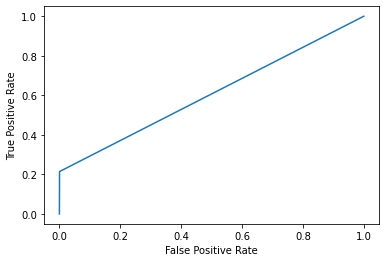

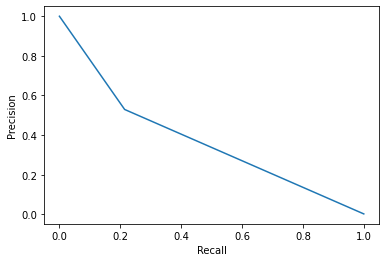

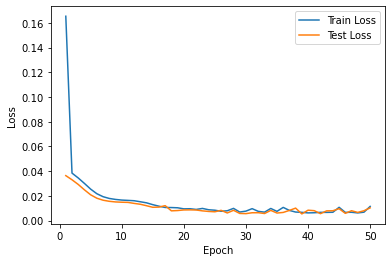

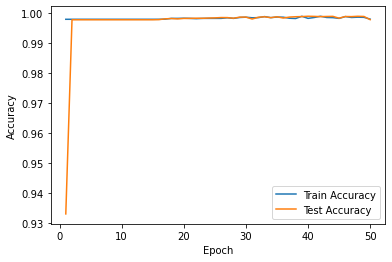

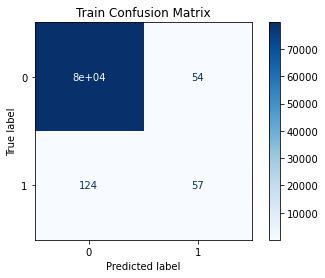

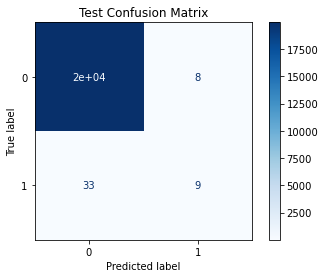

In [151]:
# Grid Search over BATCH SIZE, considering LR from [0.001, 0.0001, 0.00003, 0.00001, 0.000003]
LR =  0.0001
for (d,k) in [(1,8), (1,32), (4,16), (8,8)]:
    model = create_binary_classification_model(30, d, k)
    train_settings = TrainSettings(EPOCHS=50, LR=LR, BATCH_SIZE=64)
    net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name=f"net(d{d}_k{k})")
    stats.save_report(net=net)

# Dealing with unbalanced data: Undersampling

In [180]:
# logistic regression
from sklearn.linear_model import LogisticRegression
reg_u = LogisticRegression(max_iter = 4000)
reg_u.fit(train_u_x, train_u_y)
test_y_pred_log_reg_u = reg_u.predict(test_x) 

# support vector machine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm_u = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_u.fit(train_u_x, train_u_y)
test_y_pred_svm_u = svm_u.predict(test_x) 

# random forest
from sklearn.ensemble import RandomForestClassifier
rfc_u = RandomForestClassifier(max_depth=2, random_state=0)
rfc_u.fit(train_u_x, train_u_y)
test_y_pred_rfc_u = rfc_u.predict(test_x) 

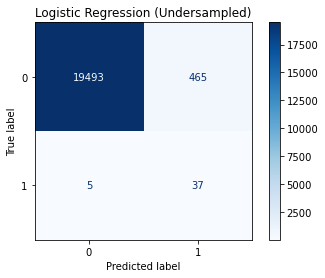

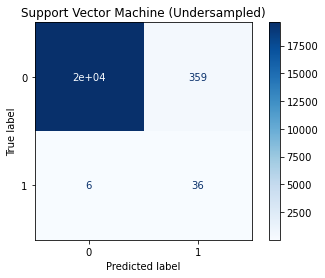

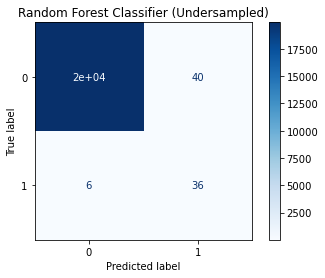

Logistic Regression: 
Accuracy: 0.9765
Precision: 0.073705179
Recall: 0.880952381
F1: 0.136029412

Support Vector Machine: 
Accuracy: 0.98175
Precision: 0.091139241
Recall: 0.857142857
F1: 0.164759725

Random Forest Classifier: 
Accuracy: 0.9977
Precision: 0.473684211
Recall: 0.857142857
F1: 0.610169492



In [186]:
plot_confusion_matrix(test_y, reg_u.predict(test_x), title="Logistic Regression (Undersampled)", path="latex/images/reg_conf1_u.png")

plot_confusion_matrix(test_y, svm_u.predict(test_x), title="Support Vector Machine (Undersampled)", path="latex/images/svm_conf1_u.png")

plot_confusion_matrix(test_y, rfc_u.predict(test_x), title="Random Forest Classifier (Undersampled)", path="latex/images/rfc_conf1_u.png")


print(tmpl.format("Logistic Regression", *acc_prec_rec_f1(test_y, test_y_pred_log_reg_u)))
print(tmpl.format("Support Vector Machine", *acc_prec_rec_f1(test_y, test_y_pred_svm_u)))
print(tmpl.format("Random Forest Classifier", *acc_prec_rec_f1(test_y, test_y_pred_rfc_u)))

using cpu for training, EPOCHS=2000, BATCH_SIZE=32, LR=0.0001
EPOCH 1:
TRAIN: train loss: 46.97166 train accuracy: 0.50000
EVAL: test loss: 95.24176 test accuracy: 0.00250
EPOCH 2:
TRAIN: train loss: 46.94862 train accuracy: 0.50000
EVAL: test loss: 95.00852 test accuracy: 0.00250
EPOCH 3:
TRAIN: train loss: 46.69172 train accuracy: 0.50000
EVAL: test loss: 94.72392 test accuracy: 0.00255
EPOCH 4:
TRAIN: train loss: 46.43178 train accuracy: 0.50000
EVAL: test loss: 94.41680 test accuracy: 0.00255
EPOCH 5:
TRAIN: train loss: 46.16171 train accuracy: 0.50000
EVAL: test loss: 94.06321 test accuracy: 0.00255
EPOCH 6:
TRAIN: train loss: 46.12276 train accuracy: 0.50000
EVAL: test loss: 93.55785 test accuracy: 0.00255
EPOCH 7:
TRAIN: train loss: 45.85065 train accuracy: 0.50000
EVAL: test loss: 93.03290 test accuracy: 0.00265
EPOCH 8:
TRAIN: train loss: 45.33642 train accuracy: 0.50000
EVAL: test loss: 91.50259 test accuracy: 0.00270
EPOCH 9:
TRAIN: train loss: 45.02887 train accuracy: 0.500

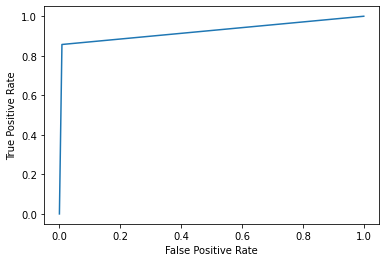

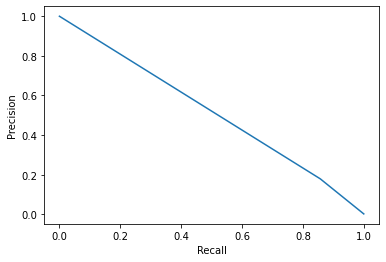

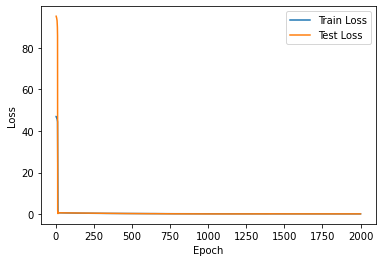

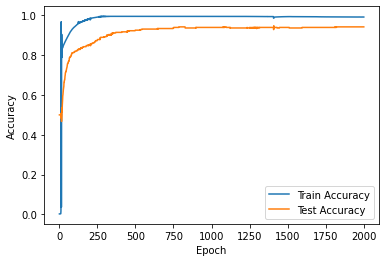

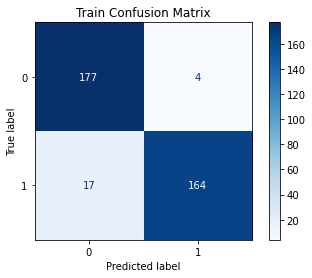

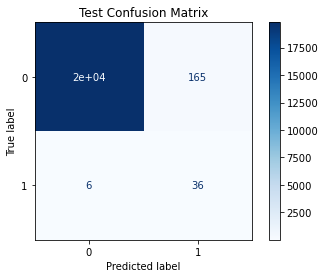

last_epoch.test_confusion
[[19793   165]
 [    6    36]]


In [200]:
# best model finally, with undersampling:
LR = 0.0001
d = 4 # depth
k = 8 # layer size
model = create_binary_classification_model(30, d, k)
train_settings = TrainSettings(EPOCHS=2000, LR=LR, BATCH_SIZE=32)
# use undersampled data
net, stats = train_network_from_model(model, torch_train_u_x, torch_train_u_y, torch_test_x, torch_test_y, train_settings, name=f"undersampled_net(d{d}_k{k})")
stats.save_report(net=net)


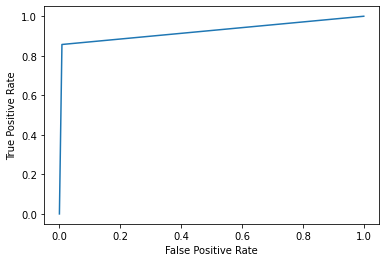

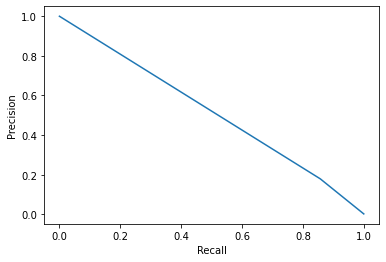

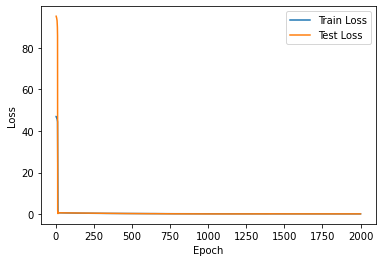

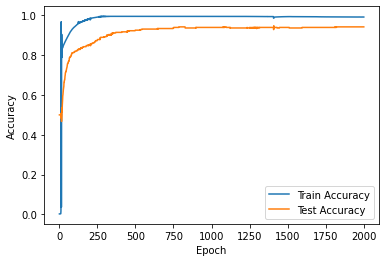

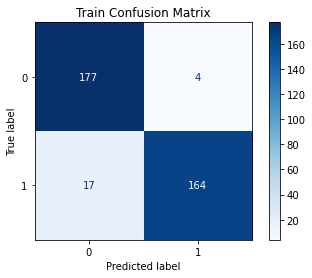

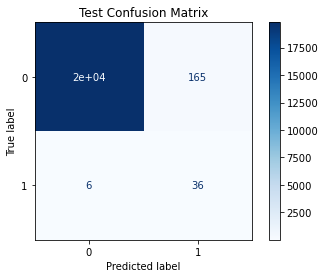

last_epoch.test_confusion
[[19793   165]
 [    6    36]]


In [201]:
stats.save_report(net=net)